In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib.lines import Line2D

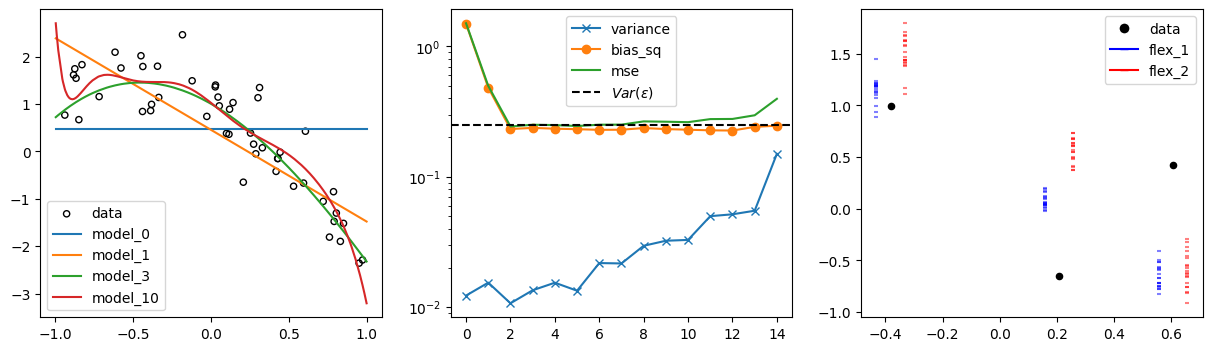

In [3]:
# define_experiment_parameters
f = Polynomial([1, -2, -1, 1, -1, -1])
sigma = 0.5
population_size = 1000
train_sample_size = 100
test_sample_size = 50
flexibility = range(0, 15)

def make_train_population_and_test_sample():
    epsilon = np.random.normal(0, sigma, population_size)
    x_population = np.linspace(-1, 1, population_size)
    y_population = f(x_population) + epsilon
    X_train_population, X_test_population, y_train_population, y_test_population = train_test_split(
        x_population, 
        y_population, 
        test_size=0.3, 
        random_state=42
    )

    test_sample_indices = np.random.choice(X_test_population.shape[0], size=test_sample_size)
    X_test_sample, y_test_sample = X_test_population[test_sample_indices], y_test_population[test_sample_indices]

    return {
        'X_train_population': X_train_population,
        'y_train_population': y_train_population,
        'X_test_population': X_test_population,
        'y_test_population': y_test_population,
        'X_test_sample': X_test_sample,
        'y_test_sample': y_test_sample,
    }


def run_experiment(train_population_and_test_sample):

    bias_squared, variance, mse = [], [], []
    y_hat_flex, models_flex = [], []

    for flex in flexibility:
        y_hat_samples = []
        mse_samples = []
        for i in range(20):
            train_sample_indices = np.random.choice(
                train_population_and_test_sample['X_train_population'].shape[0], 
                size=train_sample_size
            )
            X_train_sample = train_population_and_test_sample['X_train_population'][train_sample_indices]
            y_train_sample = train_population_and_test_sample['y_train_population'][train_sample_indices]
            model = Polynomial.fit(X_train_sample, y_train_sample, flex)
            y_hat = model(train_population_and_test_sample['X_test_sample'])
            y_hat_samples.append(y_hat)
            mse_samples.append(np.mean((y_hat - train_population_and_test_sample['y_test_sample'])**2))

        models_flex.append(model)
        y_hat_flex.append(y_hat_samples)
        bias_squared.append(np.mean((np.mean(y_hat_samples, axis=0) - train_population_and_test_sample['y_test_sample'])**2))
        variance.append(np.mean(np.var(y_hat_samples, axis=0)))
        mse.append(np.mean(mse_samples))

    y_hat_flex = np.array(y_hat_flex)

    return {
        'models_flex': models_flex,
        'y_hat_flex': y_hat_flex,
        'bias_squared': bias_squared,
        'variance': variance,
        'mse': mse,

    }


def plot_results(train_population_and_test_sample, results):

    X_test_population_sorted = np.sort(train_population_and_test_sample['X_test_population'])


    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    ax[0].set_ylab('y')
    ax[0].set_xlab('x')

    ax[0].scatter(
        train_population_and_test_sample['X_test_sample'], 
        train_population_and_test_sample['y_test_sample'], 
        s=20, edgecolor='black', facecolor='none', label='data'
    )
    for i in [0, 1, 3, 10]:
        ax[0].plot(X_test_population_sorted, results['models_flex'][i](X_test_population_sorted), label=f'model_{i}')
    ax[1].plot(flexibility, results['variance'], label='variance', marker='x')
    ax[1].plot(flexibility, results['bias_squared'], label='bias_sq', marker='o')
    ax[1].plot(flexibility, results['mse'], label='mse')
    ax[1].axhline(y=sigma**2, linestyle='--', color='black', label=r'$Var(\epsilon)$')
    ax[1].set_yscale('log')
    ax[1].legend()
    ax[0].legend()

    idx = [0, 5, 10]

    ax[2].scatter(
        train_population_and_test_sample['X_test_sample'][idx], 
        train_population_and_test_sample['y_test_sample'][idx], 
        s=20, c='black', label='data'
    )

    # plot individual predictions for flexibility level 1
    for i in range(results['y_hat_flex'][1, :, idx].shape[1]):
        ax[2].scatter(
            train_population_and_test_sample['X_test_sample'][idx] - 0.05, 
            results['y_hat_flex'][1, i, idx], 
            s=10, c='blue', alpha=0.5, marker='_'
        )

    # plot individual predictions for flexibility level 10
    for i in range(results['y_hat_flex'][10, :, idx].shape[1]):
        ax[2].scatter(
            train_population_and_test_sample['X_test_sample'][idx] + 0.05, 
            results['y_hat_flex'][10, i, idx], 
            s=10, c='red', alpha=0.5, marker='_'
        )

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8, label='data'),
        Line2D([0], [0], marker='_', color='blue', label='flex_1'),
        Line2D([0], [0], marker='_', color='red', label='flex_2')
    ]

    ax[2].legend(handles=legend_elements)

    plt.show()


train_population_and_test_sample = make_train_population_and_test_sample()
results = run_experiment(train_population_and_test_sample)
plot_results(train_population_and_test_sample, results)